In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 15

import os
from astropy.io import fits

cmap='inferno'
matplotlib.rcParams['image.cmap'] = cmap


Populating the interactive namespace from numpy and matplotlib


In [2]:
fname = '/Users/mrizzo/Downloads/starshade_spinning_modern_cube_zodi1inc60dist10_rp0ab0mz0p00sl0lcs0st0_ap0_2025_0425_0552_nm_3mas_3nm_no_background.fits'

In [3]:
data = fits.getdata(fname)
data=np.swapaxes(data,0,1)
print data.shape
fits.writeto('/Users/mrizzo/Downloads/test_starshade.fits',data,overwrite=True)

(43, 501, 501)


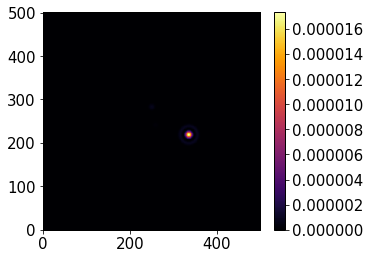

In [4]:
plt.imshow(data[0])
plt.colorbar(fraction=0.046, pad=0.04)


In [5]:
sizepix_asec = 3e-3
newsize = 0.0201
div = newsize/sizepix_asec
print div

6.7


In [6]:
from crispy.tools.detutils import frebin
newarray = []
for i in range(data.shape[0]):
    newarray.append(frebin(data[i],(int(data.shape[1]/div),int(data.shape[2]/div))))
newarray = np.array(newarray)

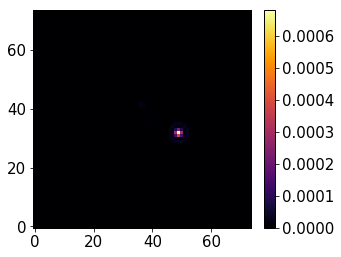

In [7]:
plt.imshow(newarray[0])
plt.colorbar(fraction=0.046, pad=0.04)


In [8]:
import os
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST_SC/')
from params import Params
par = Params()
par.BW=0.21
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [9]:
from crispy.tools.image import Image
cube = fits.HDUList(fits.PrimaryHDU(data[:,:-3,:-3].astype(np.float32)))
lamoD_asec = 0.041
cube[0].data/= 3. # divide by 3nm to obtain a density
print cube[0].data.shape
cube[0].header['LAM_C'] = 0.66
cube[0].header['PIXSIZE'] = sizepix_asec/lamoD_asec
print cube[0].header['PIXSIZE']
lams = np.linspace(660.-660.*par.BW/2.0,660.+660.*par.BW/2.0,cube[0].data.shape[0])
print lams

(43, 498, 498)
0.0731707317073
[ 590.7  594.   597.3  600.6  603.9  607.2  610.5  613.8  617.1  620.4
  623.7  627.   630.3  633.6  636.9  640.2  643.5  646.8  650.1  653.4
  656.7  660.   663.3  666.6  669.9  673.2  676.5  679.8  683.1  686.4
  689.7  693.   696.3  699.6  702.9  706.2  709.5  712.8  716.1  719.4
  722.7  726.   729.3]


In [10]:
from crispy.IFS import polychromeIFS
detectorFrame = polychromeIFS(par,lams,cube[0],parallel=True,QE=True)

crispy - INFO - The number of input pixels per lenslet is 6.833333
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/imagePlaneRot.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 56 seconds total


In [12]:
from crispy.IFS import reduceIFSMap
reduced = reduceIFSMap(par,detectorFrame,
                       name = 'starshade',
                        method='optext',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=3
                       )

crispy - INFO - Mean, median, std: (1.2841185235129132e-09, 1.788537796799179e-49, 5.0599197969525661e-09)
crispy - INFO - Reduced cube will have 21 wavelength bins
crispy - INFO - Elapsed time: 3.297973s
